In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [3]:
X_train = np.array(df_train.iloc[:, :-1])
y_train = np.array(df_train.iloc[:, -1])
X_test = np.array(df_test.iloc[:, :-1])
y_test = np.array(df_test.iloc[:, -1])

scaler = StandardScaler() # Standardise input variables

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape

(384, 8)

In [5]:
y_train.shape

(384,)

In [6]:
y_train[:10]

array([12.74, 29.68, 36.57, 38.57, 34.72, 16.99, 15.19, 28.56, 14.51,
       25.27])

In [7]:
y_test[:10]

array([15.55, 15.55, 20.71, 19.68, 19.34, 17.05, 15.98, 29.63, 24.77,
       23.93])

# Task 2a

### ORIGINAL

In [8]:
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    # posterior mean Mu and cov SIGMA with basis matrix PHI
    # and width hyperparam alph and s2
    # where alph = lam/s2

    SIGMA = np.linalg.inv(alph*np.eye(PHI.shape[0]) + (1/s2)*PHI.T@PHI)
    Mu = (1/s2)*SIGMA@PHI.T@y
    
    return Mu, SIGMA

In [9]:
def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    Mu, SIGMA = compute_posterior(PHI, y, alph, s2)
    N = PHI.shape[0]
    M = PHI.shape[1]
#     lgp = stats.multivariate_normal.logpdf()
    E_m_N = 1/(s2*2) * np.linalg.norm(y-PHI@Mu)**2 + alph/2*Mu.T@Mu
    lgp = 0.5*M*np.log(alph) + 0.5*N*np.log(1/s2) - E_m_N - 0.5*np.log(np.linalg.det(np.linalg.inv(SIGMA))) - 0.5*N*np.log(2*np.pi)
    return lgp



### MODIFIED

In [10]:
# def compute_posterior(X, y, sigma_w_2, sigma_n_2):
#     SIGMA = np.linalg.inv((1/sigma_w_2)*np.eye(X.shape[1]) + (1/sigma_n_2)*X.T@X)
#     Mu = (1/sigma_n_2)*SIGMA@X.T@y
    
# #     N = X.shape[0]
# #     shared = np.linalg.inv(X.T@X + sigma_n_2*sigma_w_2*np.eye(N))
# #     Mu = shared@X.T@y
# #     SIGMA = sigma_n_2*shared
#     return Mu, SIGMA

# def compute_log_marginal(X, y, sigma_w_2, sigma_n_2):

#     Mu, SIGMA = compute_posterior(X, y, sigma_w_2, sigma_n_2)
#     N = X.shape[0]
#     M = X.shape[1]
# #     lgp = stats.multivariate_normal.logpdf()
#     E_m_N = 1/(sigma_n_2*2) * np.linalg.norm(y-X@Mu)**2 + (1/sigma_w_2)/2*Mu.T@Mu
#     lgp = 0.5*M*np.log((1/sigma_w_2)) + 0.5*N*np.log(1/sigma_n_2) - E_m_N - 0.5*np.log(np.linalg.det(np.linalg.inv(SIGMA))) - 0.5*N*np.log(2*np.pi)
#     return lgp

### NEW VERSION

In [11]:
### USING ZERO-MEAN GAUSSIAN CONCEPT

def compute_log_marginal(X, y, sigma_n_2, sigma_w_2): # p(y|sigma_n_2, sigma_w_2)
    N = X.shape[0]
    cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
    return stats.multivariate_normal.logpdf(y, mean=None, cov=cov, allow_singular=True)
    
compute_log_marginal(X_train, y_train, 0.01, 0.01)

-10266828.784337511

### Hyperparameter grid

In [12]:
sigma_n_2_power_grid = np.linspace(-10, 10, 100)
sigma_w_2_power_grid = np.linspace(-10, 10, 100)

log_prob_list = []

for power_sigma_n_2 in tqdm(sigma_n_2_power_grid):
    for power_sigma_w_2 in sigma_w_2_power_grid:
        log_prob = compute_log_marginal(X_train, y_train, 10**power_sigma_n_2, 10**power_sigma_w_2)
        log_prob_list.append(log_prob)

100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


In [13]:
# prob_list to 2d shape
log_prob_list = np.array(log_prob_list).reshape(100, 100)

In [14]:
np.argmax(log_prob_list)

2356

In [15]:
i_max = np.unravel_index(np.argmax(log_prob_list), log_prob_list.shape)
print(i_max)

(23, 56)


In [16]:
power_sigma_n_2_opt = sigma_n_2_power_grid[i_max[0]]
power_sigma_w_2_opt = sigma_w_2_power_grid[i_max[1]]

In [17]:
print("Optimal: \npower_sigma_n_2 = {} \npower_sigma_w_2 = {} \nsigma_n_2 = {} \nsigma_w_2 = {} \nlog_prob = {}"\
      .format(power_sigma_n_2_opt, power_sigma_w_2_opt,\
              10**power_sigma_n_2_opt, 10**power_sigma_w_2_opt,\
              log_prob_list[i_max]))

Optimal: 
power_sigma_n_2 = -5.353535353535354 
power_sigma_w_2 = 1.3131313131313131 
sigma_n_2 = 4.430621457583877e-06 
sigma_w_2 = 20.565123083486515 
log_prob = -37.95516967686765


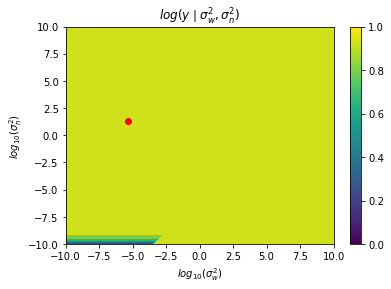

In [18]:
plt.contourf(sigma_n_2_power_grid, sigma_w_2_power_grid, log_prob_list) #[X, Y], Z
plt.scatter(power_sigma_n_2_opt, power_sigma_w_2_opt, color='red')
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

# plt.contourf(alph_power_grid, r_power_grid, prob_y) #[X, Y], Z
# plt.title("prob_y")
# plt.xlabel(r"$log_{10} (\alpha)$")
# plt.ylabel(r"$log_{10} (r)$")
# plt.colorbar()
# plt.show()

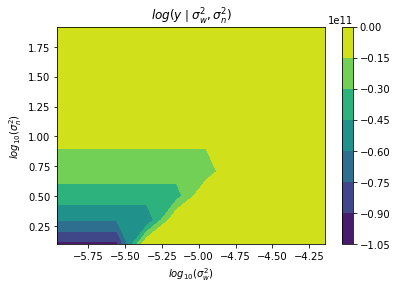

In [19]:

plt.contourf(sigma_n_2_power_grid[20:30], sigma_w_2_power_grid[50:60], log_prob_list[20:30, 50:60]) #[X, Y], Z
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

In [20]:
np.max(log_prob_list[20:30, 50:60])

-37.95516967686765

In [21]:
sigma_n_2_power_grid_mag = np.linspace(-6, -4, 100)
sigma_w_2_power_grid_mag = np.linspace(1, 2, 100)

log_prob_list_mag = []

for power_sigma_n_2 in sigma_n_2_power_grid_mag:
    for power_sigma_w_2 in sigma_w_2_power_grid_mag:
        log_prob = compute_log_marginal(X_train, y_train, 10**power_sigma_n_2, 10**power_sigma_w_2)
        log_prob_list_mag.append(log_prob)

In [22]:
# prob_list to 2d shape
log_prob_list_mag = np.array(log_prob_list_mag).reshape(100, 100)

In [23]:
i_max_mag = np.unravel_index(np.argmax(log_prob_list_mag), log_prob_list_mag.shape)
print(i_max_mag)

(40, 32)


In [24]:
log_prob_list_mag[i_max_mag]

-37.95497240664166

In [25]:
power_sigma_n_2_opt_mag = sigma_n_2_power_grid_mag[i_max_mag[0]]
power_sigma_w_2_opt_mag = sigma_w_2_power_grid_mag[i_max_mag[1]]

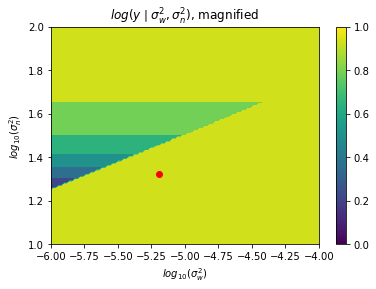

In [26]:
plt.contourf(sigma_n_2_power_grid_mag, sigma_w_2_power_grid_mag, log_prob_list_mag) #[X, Y], Z
plt.scatter(power_sigma_n_2_opt_mag, power_sigma_w_2_opt_mag, c='red')
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$, magnified")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

In [27]:
sigma_n_2_opt = 10**power_sigma_n_2_opt_mag
sigma_w_2_opt = 10**power_sigma_w_2_opt_mag

print("Optimal: \nsigma_n_2_opt = {} \nsigma_w_2_opt = {}".format(sigma_n_2_opt, sigma_w_2_opt))

Optimal: 
sigma_n_2_opt = 6.4280731172843194e-06 
sigma_w_2_opt = 21.049041445120206


### Predictions and RMSE

In [28]:
# def get_w(X, y, sigma_n_2, sigma_w_2):
#     return np.linalg.inv(X.T@X + sigma_n_2*(1/sigma_w_2)*np.eye(X.shape[1]))@X.T@y

In [29]:
def get_w(X, y, sigma_n_2, sigma_w_2):
    return np.linalg.inv(X.T@X + (1/sigma_w_2)*np.eye(X.shape[1]))@X.T@y

In [30]:
w = get_w(X_train, y_train, sigma_n_2_opt, sigma_w_2_opt)
w

array([-7.09783611, -3.84796275,  0.77760774, -4.14950714,  7.24533858,
       -0.12556796,  2.77066872,  0.2034831 ])

In [31]:
y_intercept = y_train.mean()

In [32]:
y_test_pred = X_test@w + y_intercept

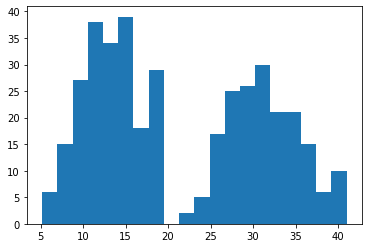

In [33]:
plt.hist(y_test_pred, bins=20)
plt.show()

In [34]:
y_test_pred[:10]

array([22.53819246, 22.42365079, 24.93578358, 24.82124192, 23.81239499,
       26.09069639, 25.74707138, 27.2438283 , 32.02773354, 31.91319187])

In [35]:
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print("test RMSE =", rmse_test)

test RMSE = 2.843446999367912


In [36]:
def error_histogram(y_pred, y_targ):
    error_list = y_pred.reshape(-1, 1) - y_targ.reshape(-1, 1)
    plt.hist(error_list, bins=20)
    plt.xlabel("Error")
    plt.ylabel("Number of samples in the bin")
    plt.show()

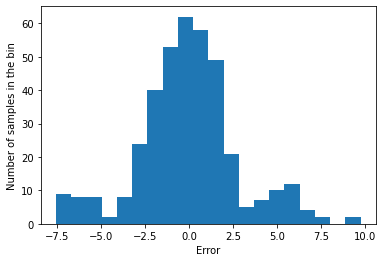

In [37]:
error_histogram(y_test_pred, y_test)

# Task 2b single alpha

In [207]:
def calc_q_w(X, t, alpha, beta, w):
    cov = np.linalg.inv(beta*X.T@X + alpha*np.eye(X.shape[1]))
    mean = beta*cov@X.T@t
    return stats.multivariate_normal.pdf(w, mean=mean, cov=cov, allow_singular=True), mean # q_w and w_new

def calc_q_alpha(X, t, alpha, w, a, b):
    a_new = a + 0.5*X.shape[1]
    b_new = b + 0.5*np.sum(w**2)
#     pdf_list = []
#     alpha_new = []
#     for i, a in enumerate(alpha):
    q_alpha_new = stats.gamma.pdf(alpha, a=a_new, scale=b_new)
    alpha_new = stats.gamma.mean(a=a_new, scale=b_new)
    return q_alpha_new, alpha_new, a_new, b_new # q_alpha and alpha_new

def calc_q_beta(X, t, beta, w, c, d):
    c_new = c + X.shape[0]/2
    d_new = d + 1/2*np.linalg.norm(t-X@w)**2
    beta_new = stats.gamma.mean(a=c_new, scale=d_new)
    return stats.gamma.pdf(beta, a=c_new, scale=d_new), beta_new, c_new, d_new # q_beta and beta_new

In [208]:
# log prob version
def calc_log_q_w(X, t, alpha, beta, w):
    cov = np.linalg.inv(beta*X.T@X + alpha*np.eye(X.shape[1]))
    mean = beta*cov@X.T@t
    return stats.multivariate_normal.logpdf(w, mean=mean, cov=cov, allow_singular=True), mean # q_w and w_new

def calc_log_q_alpha(X, t, alpha, w, a, b):
    a_new = a + 0.5*X.shape[1]
    b_new = b + 0.5*np.sum(w**2)
    q_alpha_new = stats.gamma.logpdf(alpha, a=a_new, scale=b_new)
    alpha_new = stats.gamma.mean(a=a_new, scale=b_new)
    return q_alpha_new, alpha_new, a_new, b_new # q_alpha and alpha_new

def calc_log_q_beta(X, t, beta, w, c, d):
    c_new = c + X.shape[0]/2
    d_new = d + 1/2*np.linalg.norm(t-X@w)**2
    beta_new = stats.gamma.mean(a=c_new, scale=d_new)
    return stats.gamma.logpdf(beta, a=c_new, scale=d_new), beta_new, c_new, d_new # q_beta and beta_new

In [209]:
initial = 10**-4
a = initial
b = initial
c = initial
d = initial

alpha = stats.gamma.mean(a=a, scale=b)
beta = stats.gamma.mean(a=c, scale=d)

w = np.zeros(8)

X = X_train
t = y_train


In [210]:
it = 100
prob_post_list = []
for i in tqdm(range(it)):
    q_w, w = calc_q_w(X, t, alpha, beta, w)
    q_alpha, alpha, a, b = calc_q_alpha(X, t, alpha, w, a, b)
    q_beta, beta, c, d = calc_q_beta(X, t, beta, w, c, d)
    prob_post = q_w*q_alpha*q_beta
    prob_post_list.append(prob_post)

100%|██████████| 100/100 [00:00<00:00, 2358.66it/s]


In [211]:
initial = 10**-4
a = initial
b = initial
c = initial
d = initial

alpha = stats.gamma.mean(a=a, scale=b)
beta = stats.gamma.mean(a=c, scale=d)

w = np.zeros(8)

X = X_train
t = y_train



In [212]:
it = 100
log_prob_post_list = []
for i in tqdm(range(it)):
    q_w, w = calc_log_q_w(X, t, alpha, beta, w)
    q_alpha, alpha, a, b = calc_log_q_alpha(X, t, alpha, w, a, b)
    q_beta, beta, c, d = calc_log_q_beta(X, t, beta, w, c, d)
    log_prob_post = q_w + q_alpha + q_beta
    log_prob_post_list.append(prob_post)

100%|██████████| 100/100 [00:00<00:00, 2919.97it/s]


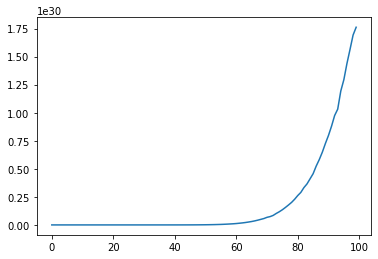

In [213]:
plt.plot(prob_post_list);

In [214]:
log_prob_post_list[:10]

[1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30,
 1.7613232156831545e+30]

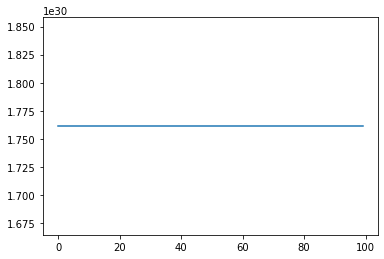

In [215]:
plt.plot(log_prob_post_list);

In [216]:
w

array([-7.23458438, -3.94212356,  0.75595735, -4.23188777,  7.2039646 ,
       -0.1251694 ,  2.77021909,  0.20406246])

In [217]:
print(f"sigma_w_2={1/alpha} \nsigma_n_2={1/beta}")

sigma_w_2=3.4325616267178905e-07 
sigma_n_2=5.075840899858351e-12


In [218]:
y_test_pred = X_test@w + y_intercept
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

In [219]:
rmse_test

2.843587960363663

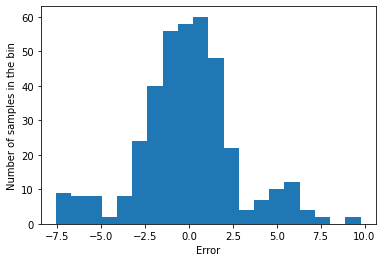

In [220]:
error_histogram(y_test_pred, y_test)

### Visualise Q for sigma_w and sigma_n

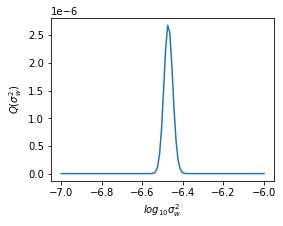

In [233]:
sigma_w_2_power_grid = np.linspace(-7, -6, 100)

prob_list = []
for power_sigma_w_2 in sigma_w_2_power_grid:
        alpha = 1/(10**power_sigma_w_2)
        q_alpha, *_ = calc_q_alpha(X, t, alpha, w, a, b)
        prob_list.append(q_alpha)
        
prob_list = np.array(prob_list)

plt.figure(figsize=(4, 3))
plt.plot(sigma_w_2_power_grid, prob_list)
plt.xlabel("$log_{10} \sigma_{w}^2$")
plt.ylabel("$Q(\sigma_{w}^2)$")
plt.show()

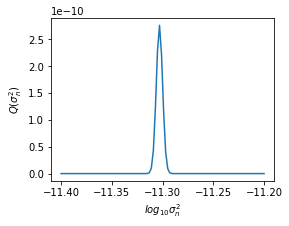

In [236]:
sigma_n_2_power_grid = np.linspace(-11.4, -11.2, 100)

prob_list = []
for power_sigma_n_2 in sigma_n_2_power_grid:
        beta = 1/(10**power_sigma_n_2)
        q_beta, *_ = calc_q_beta(X, t, beta, w, c, d)
        prob_list.append(q_beta)
        
prob_list = np.array(prob_list)

plt.figure(figsize=(4, 3))
plt.plot(sigma_n_2_power_grid, prob_list)
plt.xlabel("$log_{10} \sigma_{n}^2$")
plt.ylabel("$Q(\sigma_{n}^2)$")
plt.show()

### Visualise contour plot

In [201]:
sigma_n_2_power_grid = np.linspace(-20, 20, 100)
sigma_w_2_power_grid = np.linspace(-20, 20, 100)

log_prob_list = []

for power_sigma_n_2 in tqdm(sigma_n_2_power_grid):
    for power_sigma_w_2 in sigma_w_2_power_grid:
        alpha = 1/(10**power_sigma_w_2)
        beta = 1/(10**power_sigma_n_2)
        log_q_alpha, *_ = calc_log_q_alpha(X, t, alpha, w, a, b)
        log_q_beta, *_ = calc_log_q_beta(X, t, beta, w, c, d)
        log_prob = log_q_alpha + log_q_beta
        log_prob_list.append(log_prob)
        
log_prob_list = np.array(log_prob_list).reshape(100, 100)

100%|██████████| 100/100 [00:01<00:00, 55.65it/s]


In [202]:
i_max = np.unravel_index(np.argmax(log_prob_list), log_prob_list.shape)
print(i_max)
power_sigma_n_2_opt = sigma_n_2_power_grid[i_max[0]]
power_sigma_w_2_opt = sigma_w_2_power_grid[i_max[1]]
sigma_n_2_opt = 10**power_sigma_n_2_opt
sigma_w_2_opt = 10**power_sigma_w_2_opt

(22, 34)


In [203]:
print("Optimised:")
print(f"sigma_n_2={sigma_n_2_opt}, sigma_w_2={sigma_w_2_opt}")

Optimised:
sigma_n_2=7.742636826811278e-12, sigma_w_2=5.462277217684337e-07


In [204]:
log_prob_list[i_max]

-1719.0162977208488

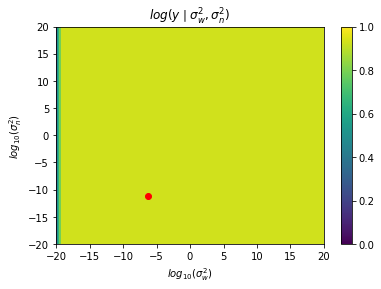

In [206]:
plt.contourf(sigma_w_2_power_grid, sigma_n_2_power_grid, log_prob_list) #[X, Y], Z
plt.scatter(power_sigma_w_2_opt, power_sigma_n_2_opt, color='red')
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

# Task 2b alpha for each weight

In [90]:
def calc_q_w(X, t, alpha, beta, w):
    cov = np.linalg.inv(beta*X.T@X + np.diag(alpha))
    mean = beta*cov@X.T@t
    return stats.multivariate_normal.pdf(w, mean=mean, cov=cov, allow_singular=True), mean # q_w and w_new

def calc_q_alpha(X, t, alpha, w, a, b):
    a_new = a + 0.5
    b_new = b + 0.5*w**2
    pdf_list = []
    alpha_new = []
    for i, a in enumerate(alpha):
        pdf_list.append(stats.gamma.pdf(alpha, a=a_new, scale=b_new[i]))
        alpha_new.append(stats.gamma.mean(a=a_new, scale=b_new[i]))
    return np.prod(pdf_list), np.array(alpha_new), a_new, b_new # q_alpha and alpha_new

def calc_q_beta(X, t, beta, w, c, d):
    c_new = c + X.shape[0]/2
    d_new = d + 1/2*np.linalg.norm(t-X@w)**2
    beta_new = stats.gamma.mean(a=c_new, scale=d_new)
    return stats.gamma.pdf(beta, a=c_new, scale=d_new), beta_new, c_new, d_new # q_beta and beta_new

In [91]:
# log prob version
def calc_log_q_w(X, t, alpha, beta, w):
    cov = np.linalg.inv(beta*X.T@X + np.diag(alpha))
    mean = beta*cov@X.T@t
    return stats.multivariate_normal.logpdf(w, mean=mean, cov=cov, allow_singular=True), mean # q_w and w_new

def calc_log_q_alpha(X, t, alpha, w, a, b):
    a_new = a + 0.5
    b_new = b + 0.5*w**2
    pdf_list = []
    alpha_new = []
    for i, a in enumerate(alpha):
        pdf_list.append(stats.gamma.logpdf(alpha, a=a_new, scale=b_new[i]))
        alpha_new.append(stats.gamma.mean(a=a_new, scale=b_new[i]))
    return np.sum(pdf_list), np.array(alpha_new), a_new, b_new # q_alpha and alpha_new

def calc_log_q_beta(X, t, beta, w, c, d):
    c_new = c + X.shape[0]/2
    d_new = d + 1/2*np.linalg.norm(t-X@w)**2
    beta_new = stats.gamma.mean(a=c_new, scale=d_new)
    return stats.gamma.logpdf(beta, a=c_new, scale=d_new), beta_new, c_new, d_new # q_beta and beta_new

In [92]:
initial = 10**-6
a = initial
b = np.full(8, initial)
c = initial
d = initial

alpha = np.full(8, stats.gamma.mean(a=a, scale=b[0]))
beta = stats.gamma.mean(a=c, scale=d)

w = np.zeros(8)

X = X_train
t = y_train


In [93]:
it = 100
prob_post_list = []
for i in tqdm(range(it)):
    q_w, w = calc_q_w(X, t, alpha, beta, w)
    q_alpha, alpha, a, b = calc_q_alpha(X, t, alpha, w, a, b)
    q_beta, beta, c, d = calc_q_beta(X, t, beta, w, c, d)
    prob_post = q_w*q_alpha*q_beta
    prob_post_list.append(prob_post)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jihoon/miniforge3/envs/atf2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-93-662fc1a406a2>:7: RuntimeWarning: invalid value encountered in double_scalars
  prob_post = q_w*q_alpha*q_beta
100%|██████████| 100/100 [00:00<00:00, 937.12it/s]


In [94]:
it = 100
log_prob_post_list = []
for i in tqdm(range(it)):
    q_w, w = calc_log_q_w(X, t, alpha, beta, w)
    q_alpha, alpha, a, b = calc_log_q_alpha(X, t, alpha, w, a, b)
    q_beta, beta, c, d = calc_log_q_beta(X, t, beta, w, c, d)
    log_prob_post = q_w + q_alpha + q_beta
    log_prob_post_list.append(prob_post)

100%|██████████| 100/100 [00:00<00:00, 1093.47it/s]


In [95]:
w

array([-7.23462545, -4.09458958,  0.82897397, -4.0768678 ,  7.2039515 ,
       -0.12516927,  2.77021895,  0.20406264])

In [96]:
print(f"sigma_w_2={1/alpha} \nsigma_n_2={1/beta}")

sigma_w_2=[1.91492372e-06 5.97782282e-06 1.44708453e-04 6.02964627e-06
 1.92562341e-06 6.38022278e-03 1.30306655e-05 2.40245680e-03] 
sigma_n_2=1.2689606317935847e-12


In [97]:
y_test_pred = X_test@w + y_intercept
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

In [98]:
rmse_test

2.8435880498724786

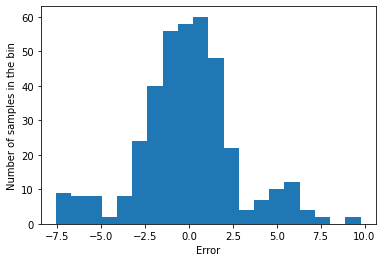

In [99]:
error_histogram(y_test_pred, y_test)

### Visualise contour plot

In [100]:
sigma_n_2_power_grid = np.linspace(-10, 10, 100)
sigma_w_2_power_grid = np.linspace(-10, 10, 100)

log_prob_list = []

for power_sigma_n_2 in tqdm(sigma_n_2_power_grid):
    for power_sigma_w_2 in sigma_w_2_power_grid:
        alpha = np.full(8, 1/(10**power_sigma_w_2))
        beta = 1/(10**power_sigma_n_2)
        log_q_alpha, *_ = calc_log_q_alpha(X, t, alpha, w, a, b)
        log_q_beta, *_ = calc_log_q_beta(X, t, beta, w, c, d)
        log_prob = log_q_alpha + log_q_beta
        log_prob_list.append(log_prob)
        
log_prob_list = np.array(log_prob_list).reshape(100, 100)

100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


In [101]:
i_max = np.unravel_index(np.argmax(log_prob_list), log_prob_list.shape)
print(i_max)
power_sigma_n_2_opt = sigma_n_2_power_grid[i_max[0]]
power_sigma_w_2_opt = sigma_w_2_power_grid[i_max[1]]

(0, 35)


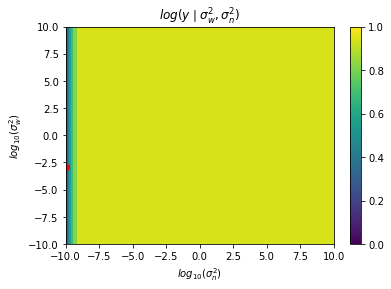

In [102]:
plt.contourf(sigma_n_2_power_grid, sigma_w_2_power_grid, log_prob_list) #[X, Y], Z
plt.scatter(power_sigma_n_2_opt, power_sigma_w_2_opt, color='red')
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$")
plt.xlabel(r"$log_{10} (\sigma_n^2)$")
plt.ylabel(r"$log_{10} (\sigma_w^2)$")
plt.colorbar()
plt.show()

In [103]:
log_prob_list

array([[-7.12937982e+10, -4.47746022e+10, -2.81197753e+10, ...,
        -3.30638330e+05, -3.33600525e+05, -3.36562719e+05],
       [-7.12938160e+10, -4.47746199e+10, -2.81197930e+10, ...,
        -3.48409303e+05, -3.51371498e+05, -3.54333692e+05],
       [-7.12938339e+10, -4.47746378e+10, -2.81198109e+10, ...,
        -3.66247362e+05, -3.69209556e+05, -3.72171751e+05],
       ...,
       [-7.12955390e+10, -4.47763430e+10, -2.81215160e+10, ...,
        -2.07143205e+06, -2.07439424e+06, -2.07735644e+06],
       [-7.12955570e+10, -4.47763609e+10, -2.81215340e+10, ...,
        -2.08938337e+06, -2.09234557e+06, -2.09530776e+06],
       [-7.12955749e+10, -4.47763789e+10, -2.81215519e+10, ...,
        -2.10733470e+06, -2.11029689e+06, -2.11325909e+06]])

### Visualise Q for sigma_w and sigma_n

In [104]:
print(1/alpha, 1/beta)

[1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10] 10000000000.0
